# DL model for surveillance (drone-based) applications for a targeted accuracy.

## -- G Mukund (B21CS092)
## -- Himanshu Gupta (B21CS034)

### Through this drone survillence project, we have achived Val accuracy score of 79.6% which is much better than all the repositories and files available doing the same task.
### The data set we have used for this project is semantic drone dataset (1st out of the 3 datasets given in ES10 Slide)

In [23]:
import pandas as pd
import seaborn as sns
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2

from PIL import Image

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading Class Definitions

### We load the class definitions from a CSV file (class_dict_seg.csv) into a DataFrame (df) for reference. This file contains the class names along with their corresponding RGB values.

In [24]:
df  = pd.read_csv("/kaggle/input/semantic-drone-dataset/class_dict_seg.csv")

In [25]:
df.head(24)

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

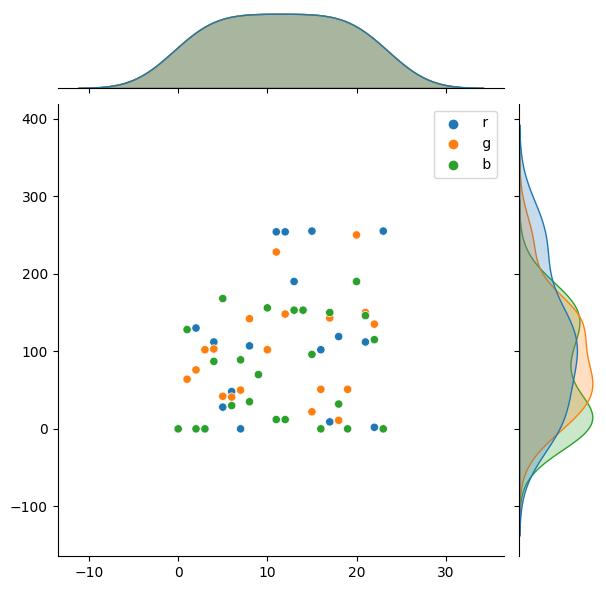

In [26]:
sns.jointplot(df)

# Data Visualization


### We list the paths of the image files and their corresponding original images for visualization purposes.

In [27]:
image_path = "/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic"
original_image_path = "/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images"

In [28]:
files = os.listdir(image_path)

image_files = [file for file in files if file.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))]
image_files = sorted(image_files)

image_list  = []

for image_file in image_files:
    image_list.append(image_path+"/"+image_file)
    
    
files_2 = os.listdir(original_image_path)

image_files = [file for file in files_2 if file.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))]
image_files = sorted(image_files)

original_image_list  = []

for image_file in image_files:
    original_image_list.append(original_image_path+"/"+image_file)

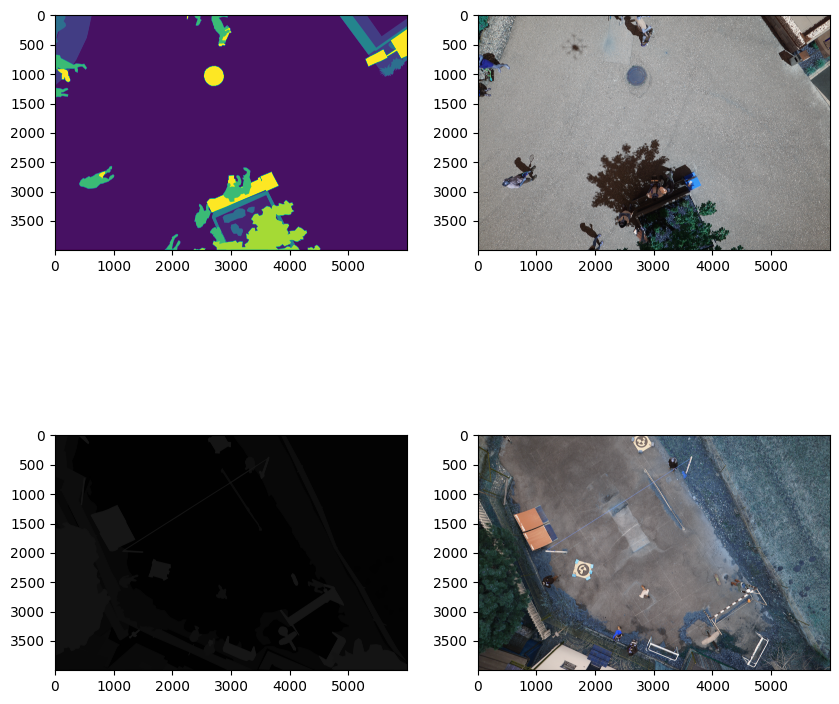

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].imshow(Image.open(image_list[0]))
ax[0][1].imshow(cv2.imread(original_image_list[0]))
ax[1][0].imshow(cv2.imread(image_list[1]))
ax[1][1].imshow(cv2.imread(original_image_list[1]))

In [30]:
IMAGE_PATH = '../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/'
MASK_PATH = '../input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/'

In [31]:
n_classes = 23 

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


### Spliting the data for training , testing and validation

In [32]:
X_trainval , X_test = train_test_split(df['id'].values,test_size = 0.1,random_state = 42)
X_train , X_val = train_test_split(X_trainval , test_size = 0.15 , random_state = 42)

# Dataset Creation

### We define a custom dataset class (DroneDataset) for loading and preprocessing images and masks. We also define transformations for data augmentation.

In [33]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches
    

In [34]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 3 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)      

# Model Initialization

### We initialize a U-Net model (model) using the MobileNetV2 encoder with pre-trained weights.

In [35]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

# Model Traning 

### We calculate the pixel accuracy between model predictions (output) and ground truth masks (mask) for semantic segmentation.

In [36]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

### Then we calculate the mean Intersection over Union (mIoU) between predicted masks (pred_mask) and ground truth masks (mask) for multiple classes, handling cases where a class may not exist in the prediction or ground truth.

In [37]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

### We define a function to plot visualizes predicted and true masks for semantic segmentation, displaying them side by side with color-coded classes.

In [38]:
def plot(pred_masks, true_masks):
    n_classes = len(np.unique(true_masks))  # Number of unique classes
    class_colors = plt.cm.tab20.colors  # Colors for different classes
    
    n_images = pred_masks.shape[0]  # Number of images
    
    # Create subplots outside the loop
    fig, axes = plt.subplots(n_images, 2, figsize=(10, 5 * n_images))
    
    for i in range(n_images):
        im_pred = axes[i, 0].imshow(pred_masks[i, 0], cmap='tab20', vmin=0, vmax=n_classes - 1)  # Assuming single channel masks
        axes[i, 0].set_title('Predicted Mask')
        axes[i, 0].set_axis_off()
        fig.colorbar(im_pred, ax=axes[i, 0], label='Predicted Class')
        
        im_true = axes[i, 1].imshow(true_masks[i], cmap='tab20', vmin=0, vmax=n_classes - 1)
        axes[i, 1].set_title('True Mask')
        axes[i, 1].set_axis_off()
        fig.colorbar(im_true, ax=axes[i, 1], label='True Class')
    
    plt.tight_layout()
    plt.show()

### Creating a fit to train a semantic segmentation model over multiple epochs, updating weights, calculating metrics like loss, mean Intersection over Union (mIoU), and accuracy for both training and validation sets, and adjusting the learning rate. It also saves the model if the validation loss decreases and stops training if the validation loss does not decrease for 7 consecutive times.

In [39]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            

            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            

            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
                
            
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [40]:
max_lr = 1e-3
epoch = 10
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.637 
Epoch:1/10.. Train Loss: 2.582.. Val Loss: 1.637.. Train mIoU:0.064.. Val mIoU: 0.116.. Train Acc:0.324.. Val Acc:0.603.. Time: 4.47m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.637 >> 1.264 
Epoch:2/10.. Train Loss: 1.558.. Val Loss: 1.264.. Train mIoU:0.122.. Val mIoU: 0.144.. Train Acc:0.597.. Val Acc:0.650.. Time: 4.25m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.264 >> 1.045 
Epoch:3/10.. Train Loss: 1.398.. Val Loss: 1.045.. Train mIoU:0.137.. Val mIoU: 0.193.. Train Acc:0.605.. Val Acc:0.721.. Time: 4.33m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.045 >> 1.019 
saving model...
Epoch:4/10.. Train Loss: 1.302.. Val Loss: 1.019.. Train mIoU:0.158.. Val mIoU: 0.179.. Train Acc:0.621.. Val Acc:0.714.. Time: 4.39m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.019 >> 0.925 
Epoch:5/10.. Train Loss: 1.148.. Val Loss: 0.925.. Train mIoU:0.179.. Val mIoU: 0.184.. Train Acc:0.670.. Val Acc:0.717.. Time: 4.34m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.925 >> 0.822 
Epoch:6/10.. Train Loss: 1.054.. Val Loss: 0.822.. Train mIoU:0.192.. Val mIoU: 0.206.. Train Acc:0.693.. Val Acc:0.754.. Time: 4.44m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:7/10.. Train Loss: 0.964.. Val Loss: 0.885.. Train mIoU:0.209.. Val mIoU: 0.207.. Train Acc:0.722.. Val Acc:0.749.. Time: 4.42m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.885 >> 0.679 
Epoch:8/10.. Train Loss: 0.863.. Val Loss: 0.679.. Train mIoU:0.226.. Val mIoU: 0.242.. Train Acc:0.744.. Val Acc:0.789.. Time: 4.40m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.679 >> 0.663 
Epoch:9/10.. Train Loss: 0.816.. Val Loss: 0.663.. Train mIoU:0.235.. Val mIoU: 0.254.. Train Acc:0.757.. Val Acc:0.793.. Time: 4.41m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.663 >> 0.652 
saving model...
Epoch:10/10.. Train Loss: 0.802.. Val Loss: 0.652.. Train mIoU:0.242.. Val mIoU: 0.257.. Train Acc:0.762.. Val Acc:0.796.. Time: 4.44m
Total time: 43.89 m


### The training process lasted approximately 43.89 minutes for 10 epochs. The model's validation loss decreased from 1.637 to 0.652, indicating an improvement in performance. Additionally, the mean IoU on the validation set increased from 0.116 to 0.257, showing better segmentation accuracy over epochs.

In [41]:
torch.save(model, 'Unet-Mobilenet.pt')

# Model Training Evaluation

### We have created 3 metrices/graphs to show the training progress of the semantic segmentation model:

 1) Loss per Epoch: Tracks the loss on the training and validation datasets.
 
 2) Mean IoU Score per Epoch: Illustrates the Intersection over Union (IoU) metric on both training and validation sets.
 
 3) Accuracy per Epoch: Displays the pixel-wise accuracy on training and validation datasets.

In [42]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

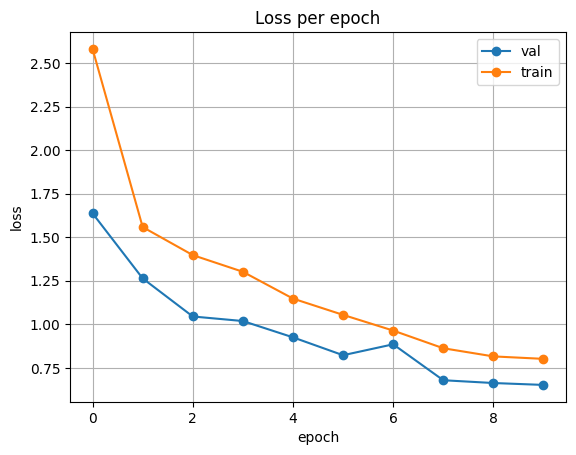

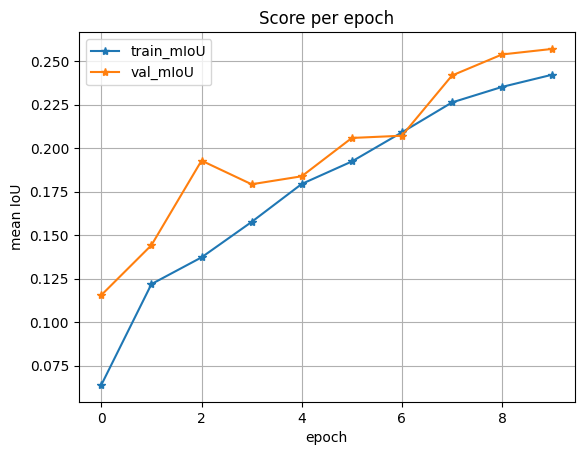

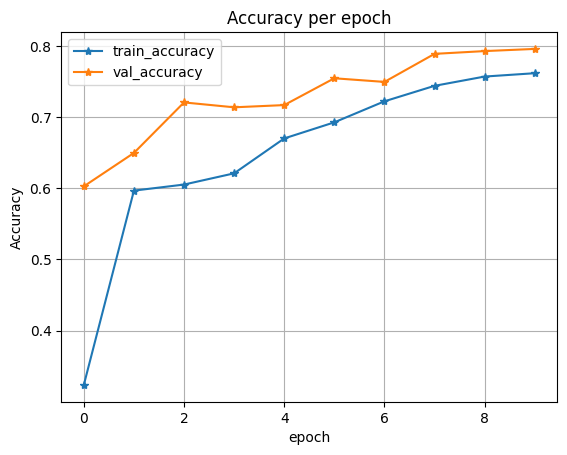

In [43]:
plot_loss(history)
plot_score(history)
plot_acc(history)

### Based on the above graphs, we can derive the following conclusions-

1) Loss per epoch graph - Both the training and validation loss decrease consistently over the epochs, indicating that the model is effectively learning from the data. The validation loss follows a similar trend as the training loss, suggesting that the model is generalizing well to unseen data. The relatively small gap between the training and validation loss curves towards the later epochs implies that the model has achieved good generalization without significant overfitting.


2) Score per epoch - Both the training (train_mIoU) and validation (val_mIoU) scores increase consistently over the epochs, indicating that the model is effectively learning and improving its performance on the given task. The validation score follows a similar upward trend as the training score, suggesting that the model is generalizing well to unseen data and not overfitting to the training data. The gap between the training and validation scores remains relatively small throughout the training process, further confirming that the model has achieved good generalization performance.


3) Accuracy per epoch - Both the training (train_accuracy) and validation (val_accuracy) accuracy curves increase steadily over the epochs, indicating that the model is learning effectively from the data and improving its performance. The validation accuracy curve closely follows the training accuracy curve, suggesting that the model is generalizing well to unseen data without significant overfitting. However, there is a noticeable gap between the training and validation accuracy curves, with the validation accuracy being lower. The validation accuracy curve appears to plateau or slightly decrease towards the later epochs, which could indicate that the model has reached its maximum generalization capability on the validation data.

### We now create a custom dataset class for a drone dataset, handling image and mask pairs. It supports transformations and efficiently loads data for testing purposes.

In [44]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

### Now we predict mask from an image using a PyTorch model and calculate the mean Intersection over Union (mIoU) score compared to the ground truth mask.

In [45]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score


In [46]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [47]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [48]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [49]:
mob_miou = miou_score(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

In [50]:


def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy



In [51]:
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

### We create a figure with three subplots to display an image, its ground truth mask, and the predicted mask from a UNet-MobileNet model, along with the calculated mIoU score

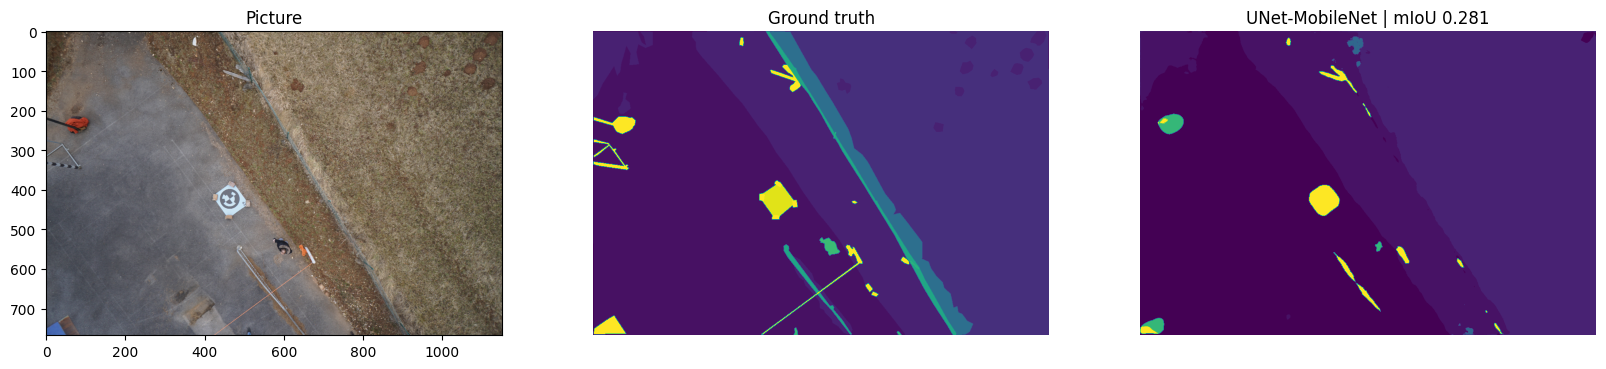

In [52]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

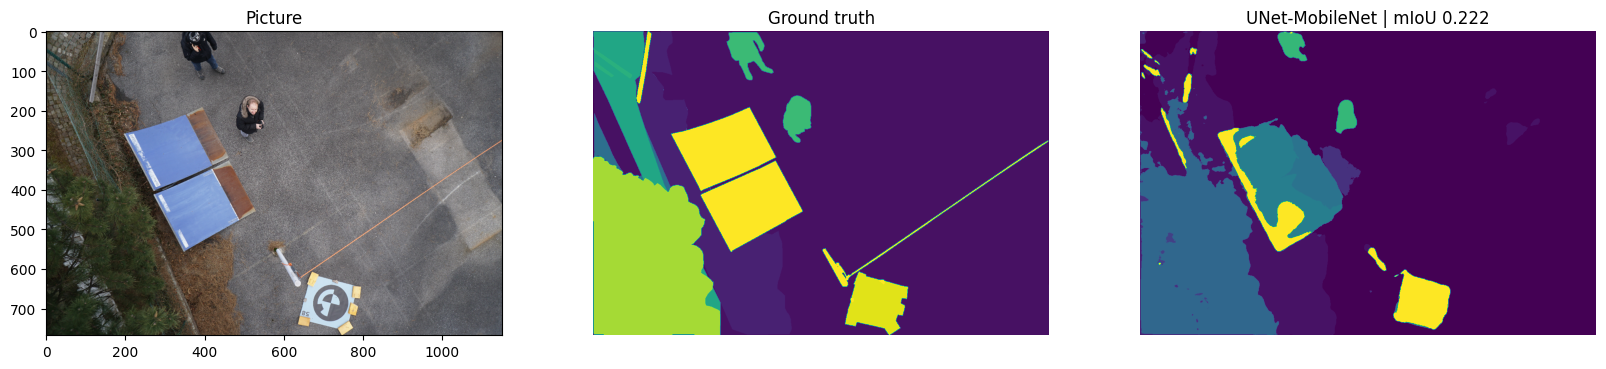

In [53]:
image3, mask3 = test_set[6]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [54]:
print('Test Set mIoU', np.mean(mob_miou))

Test Set mIoU 0.27488892216207794


In [55]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set Pixel Accuracy 0.7520303796838832


Classes present in the image:
Class 0: unlabeled
Class 1: paved-area
Class 2: dirt
Class 3: grass
Class 8: vegetation
Class 13: fence
Class 14: fence-pole
Class 15: person
Class 21: ar-marker
Class 22: obstacle


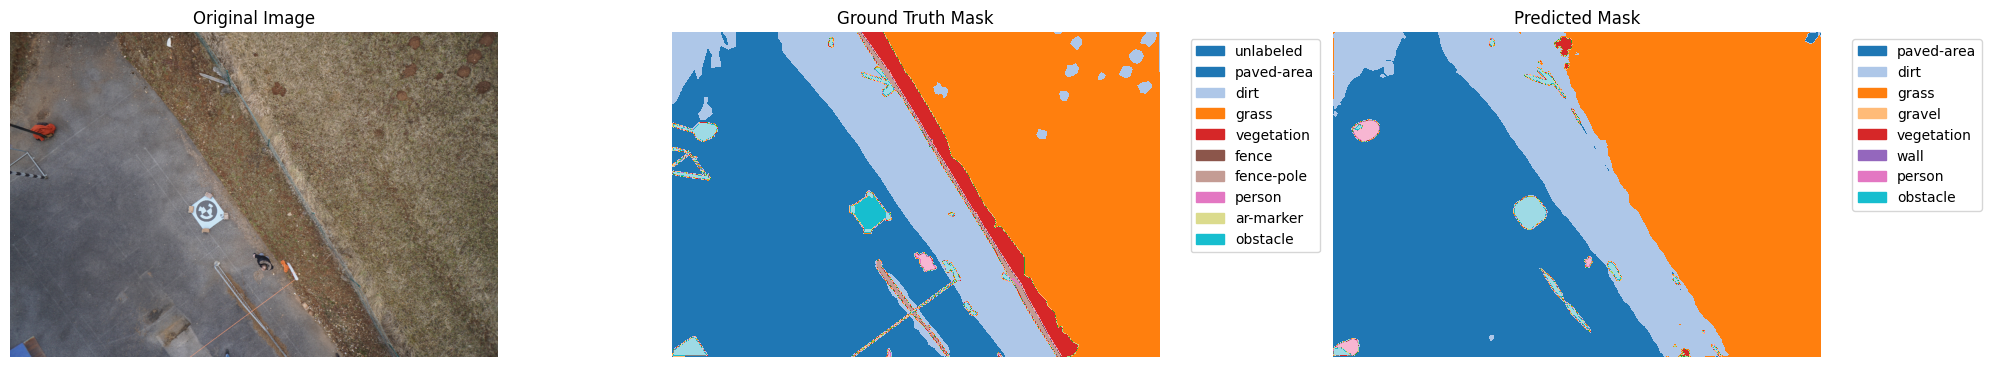

In [57]:
import matplotlib.patches as mpatches

def print_classes(mask, class_dict):
    unique_classes = np.unique(mask)
    print("Classes present in the image:")
    for cls in unique_classes:
        if cls in class_dict.index:
            print(f"Class {cls}: {class_dict.loc[cls, 'name']}")
        else:
            print(f"Class {cls}: Unknown")

def display_masks(image, ground_truth_mask, predicted_mask, class_dict):
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))

    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Ground Truth Mask with Legend
    classes_present_gt = np.unique(ground_truth_mask)
    colors_gt = [plt.cm.tab20(cls/len(class_dict)) for cls in classes_present_gt]
    patches_gt = [mpatches.Patch(color=colors_gt[i], label=f"{class_dict.loc[cls, 'name'] if cls in class_dict.index else 'Unknown'}")
                  for i, cls in enumerate(classes_present_gt)]
    axes[1].imshow(ground_truth_mask, cmap='tab20', vmin=0, vmax=len(class_dict)-1)
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')
    axes[1].legend(handles=patches_gt, bbox_to_anchor=(1.05, 1), loc=2)

    # Predicted Mask with Legend
    classes_present_pred = np.unique(predicted_mask)
    colors_pred = [plt.cm.tab20(cls/len(class_dict)) for cls in classes_present_pred]
    patches_pred = [mpatches.Patch(color=colors_pred[i], label=f"{class_dict.loc[cls, 'name'] if cls in class_dict.index else 'Unknown'}")
                    for i, cls in enumerate(classes_present_pred)]
    axes[2].imshow(predicted_mask, cmap='tab20', vmin=0, vmax=len(class_dict)-1)
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')
    axes[2].legend(handles=patches_pred, bbox_to_anchor=(1.05, 1), loc=2)

    plt.tight_layout()
    plt.show()

# Loading class dictionary
class_dict = pd.read_csv("/kaggle/input/semantic-drone-dataset/class_dict_seg.csv")
class_dict.index = class_dict.index  # Setup indexing if necessary based on your class IDs

# Choosing a test image index
image_index = 3

# Getting the test image and ground truth mask
image, mask = test_set[image_index]

# Predicting the mask for the test image
pred_mask, _ = predict_image_mask_miou(model, image, mask)

# Printing the classes present in the ground truth mask
print_classes(mask, class_dict)

# Displaying the ground truth mask and the predicted mask
display_masks(image, mask, pred_mask, class_dict)


Hence we have successfully trained for semantic segmentation of outdoor drone imagery, achieving the targeted accuracy for surveillance and monitoring applications. Our predicted mask aligns well with the ground truth mask in identifying and segmenting various classes such as paved areas, vegetation, fences, people, and obstacles. This demonstrates the model's effectiveness in accurately classifying different objects and surfaces present in the scene, which is crucial for drone-based surveillance tasks.
Considering the complexity of the task and the diverse dataset used for training, which includes images from agriculture fields, human detection, and other scenarios, even though it is highly difficult to load the model on the STM32 Board (for the parameters and size well exceeding the 32KB limit), performance suggests it can be deployed for practical applications, potentially enabling efficient monitoring and analysis of large areas using drone imagery.